## Démonstration :  utilisation de tesseract pour l'object detection avec notre model de reconnaissance de caractère 

In [1]:
### Don't forget to add image directory at the same place of this file

### Import

In [1]:
import pandas as pd
import cv2
import numpy as np
import string
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image



import pytesseract
from pytesseract import Output


import itertools # Pour créer des iterateurs

# Functions file
import utils.functions as functions
from utils.SamplePreprocessor import preprocess



### Parametres

In [2]:
# CONSTANTES
PATH  = ''
CSV_FILE = 'forms.csv'
IMG_SIZE = (128, 32)
MAX_TEXT_LEN = 32
# directory name where pretrained model is saved
PRETRAINED_MODEL = 'model_08112021_allData_final'

# Variables
paths = []
array_pictures = []
array_words = []

In [4]:
# lecture du forms.csv
coding: 'utf-8'
df = pd.read_csv(CSV_FILE, encoding='latin-1')

In [5]:
#importation de notre modele
model = keras.models.load_model(PRETRAINED_MODEL)

### Sélection aléatoire d'un formulaire

In [10]:
#Selection d'un formulaire aléatoire de notre dataset
dfsample=df.sample(n=2)
dfsample=dfsample.reset_index(drop=True)


# chargement de l'image ,création d'une copy pour affichage finale, convertion en nuance de gris 
imgs = cv2.imread(dfsample.loc[0,'path'])
image= cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)


In [11]:
# Preprocess de l'image pour ne garder que le texte manuscrit de l'image 
image = functions.preprocess_forms(image)


### Utilisation du modèle

In [13]:
# Utilisation de Tesseract avec un dataframe comme output
d = pytesseract.image_to_data(image, output_type='data.frame')
# Selection des lignes correspondants au boxing des mots du texte + reset index
d = d[(d['level'] == 5)]
d=d.reset_index()

# Boucle sur chaque ligne de notre dataframe pour traiter chaque box
n_boxes = len(d['level'])
for i in range(n_boxes):
    array_pictures = []
    # définition des coordonnées de chaque box
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    # Création d'un rectangle vert sur l'image original
    cv2.rectangle(imgs, (x, y), (x + w, y + h), (5, 255,5), 2)
    # Cropping an image ( création d'une image correspondant à la box)
    cropped_image = image[y:y+h, x:x+w]
    # Preprocess de l'image (resize 128 32)
    cropped_image = preprocess(cropped_image, IMG_SIZE)
    #Ajout de l'image à un array numpy
    array_pictures.append(cropped_image)
    array_pictures = np.array(array_pictures)
    img = tf.expand_dims(array_pictures, axis = 3)
    # Prédiction de notre box
    mod = model.predict(img)
    #Décodage du mots
    charList = list(string.ascii_letters)+[' ']
    decodage = functions.greedy_decoder(mod, charList)
    
    text=decodage[0]
    
    imgs = functions.print_resultat(imgs,text,x,y)
    
  

### Affichage du résultat

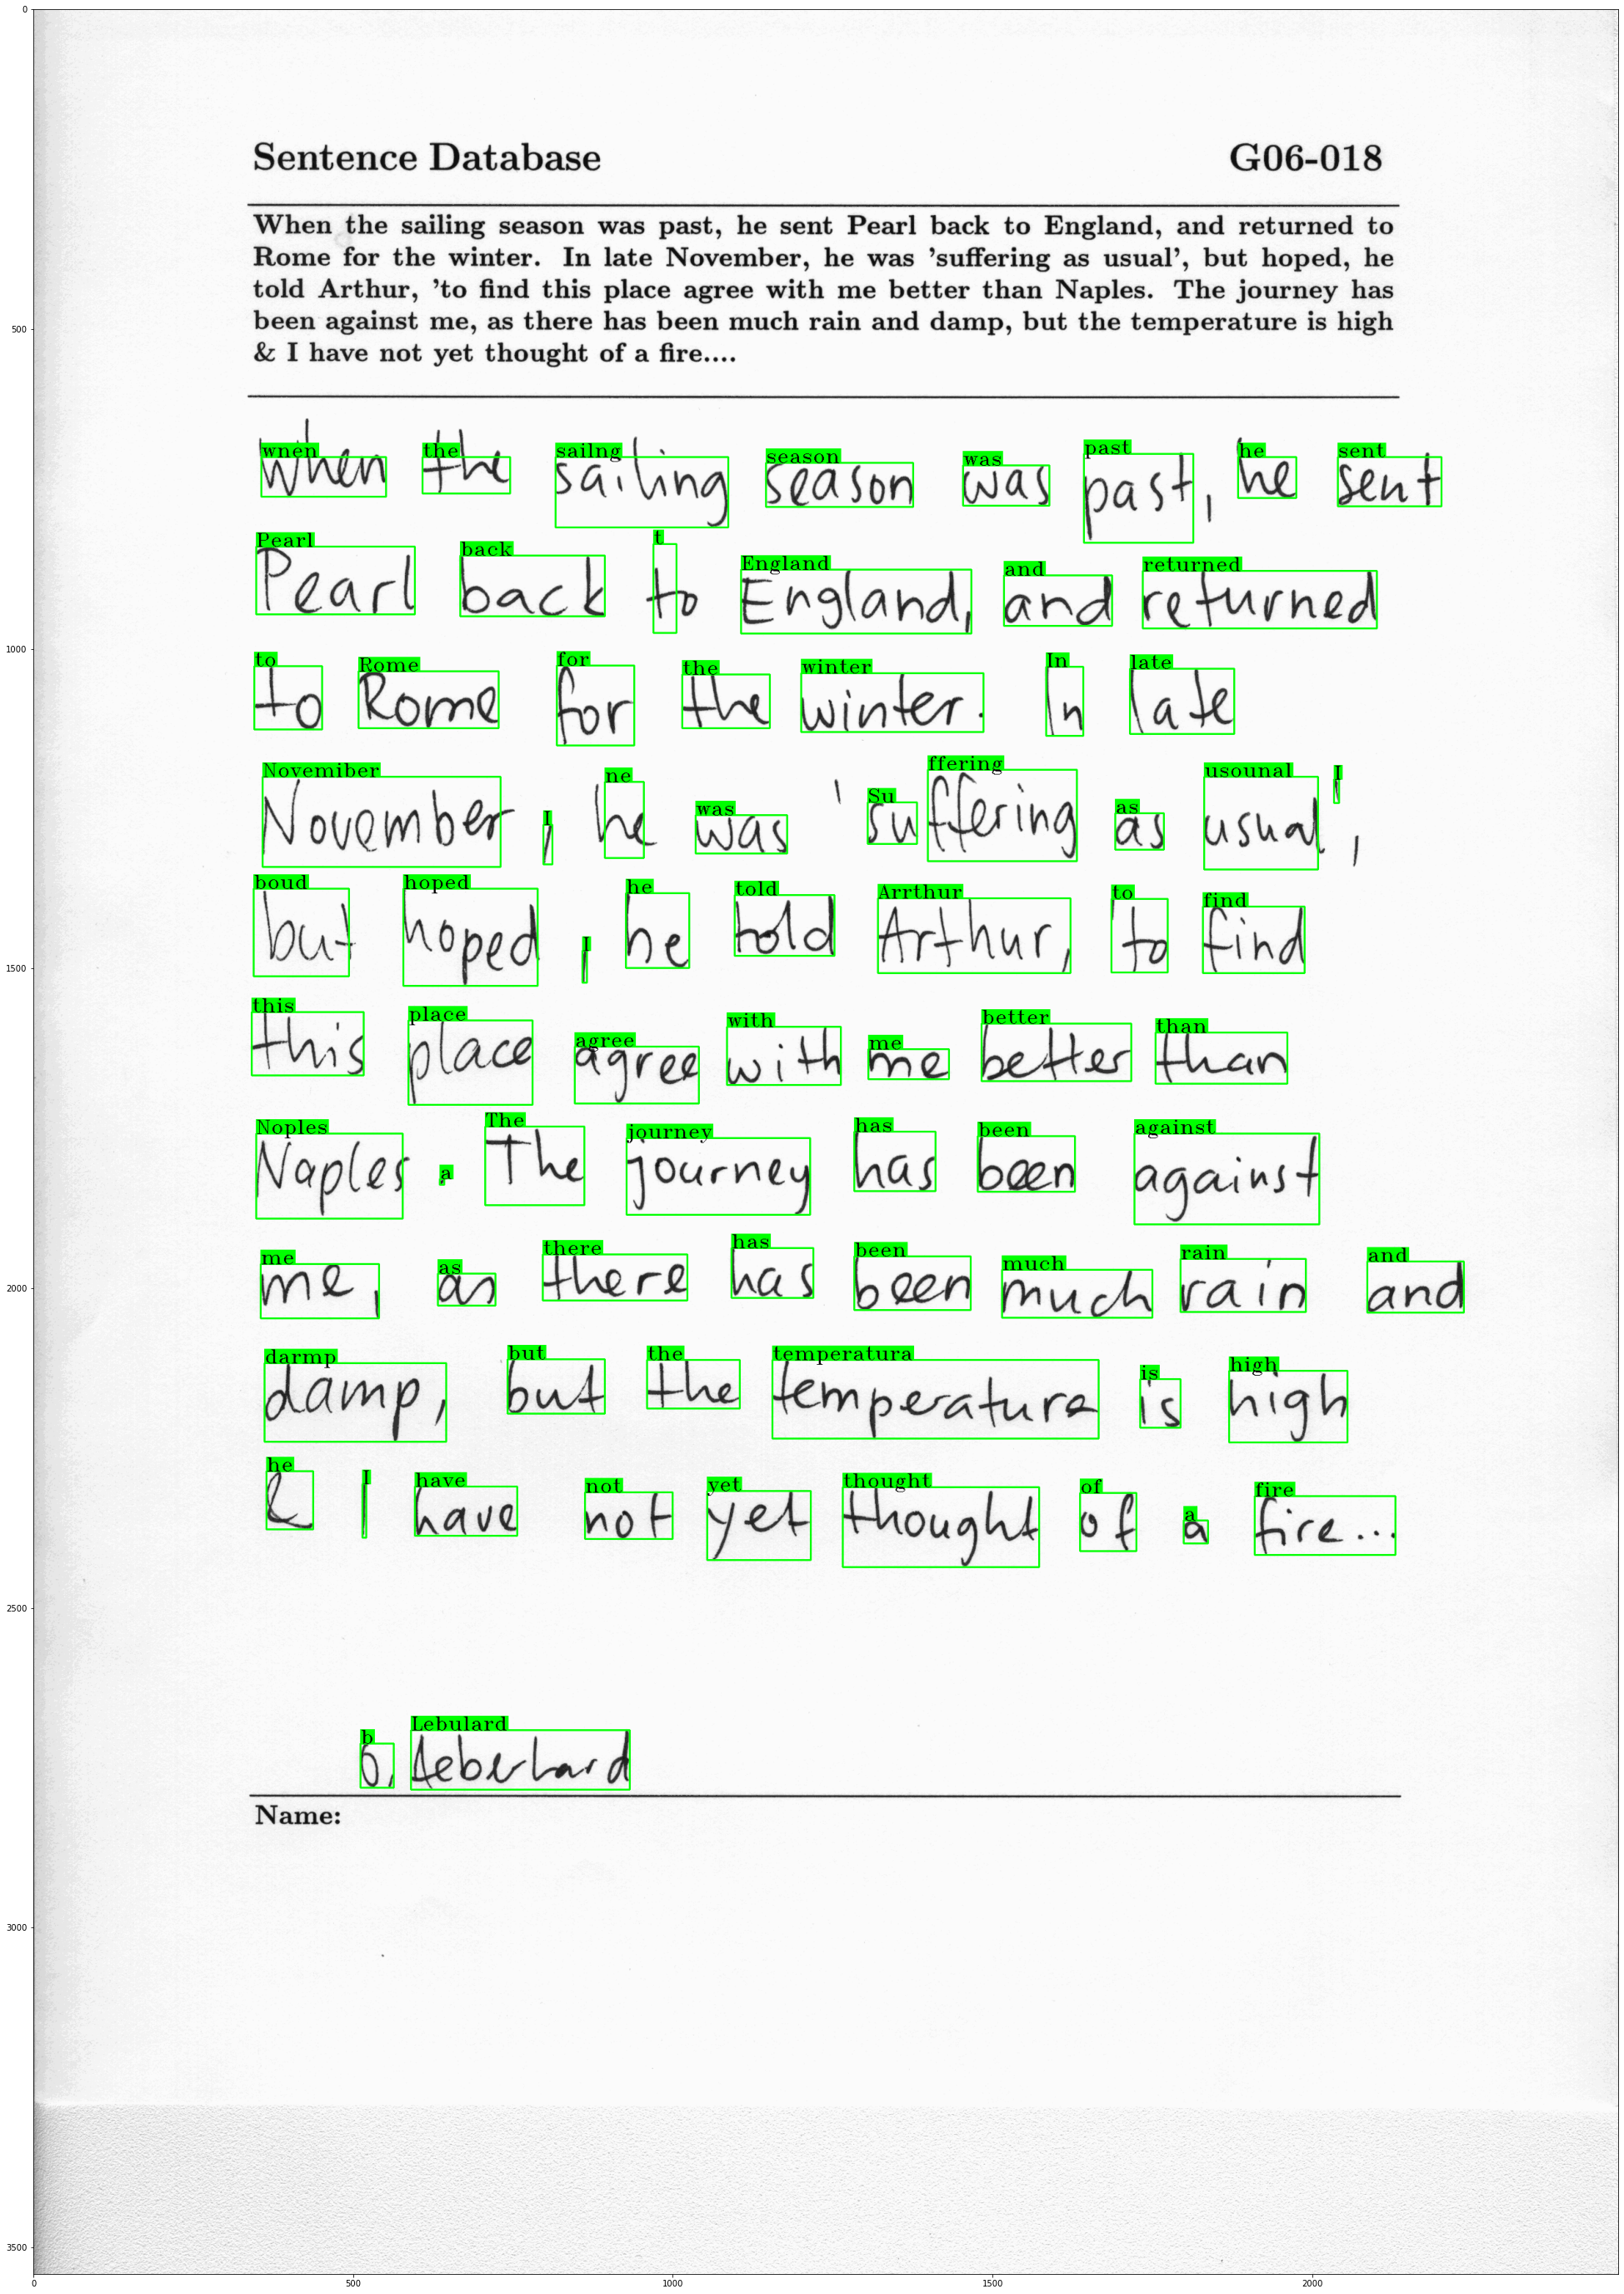

In [14]:
# affichage du résultat
plt.figure(figsize=(100,50))
plt.imshow(imgs,cmap='gray')
